In [2]:
suppressMessages(library(randomForest))
suppressMessages(library(caret))
suppressMessages(library(Metrics))
suppressMessages(library(lattice))
suppressMessages(library(ggplot2))

In [3]:
# reading data file ~ credit.csv # readi 
# taken from https://archive.ics.uci.edu/ml/datasets/Statlog+%28German+Credit+Data%29

# credit.csv is composed of qualitative and quantitative variables.
# For this exercise we will focus on all of the features

creditsub <- read.csv(file = '/home/dell/R_programming/case studies/trees/MachineLearning/data/credit.csv', 
                      header = T)

# Let's take a look at the dataframe
head(creditsub)

checking_balance,months_loan_duration,credit_history,purpose,amount,savings_balance,employment_duration,percent_of_income,years_at_residence,age,other_credit,housing,existing_loans_count,job,dependents,phone,default
< 0 DM,6,critical,furniture/appliances,1169,unknown,> 7 years,4,4,67,none,own,2,skilled,1,yes,no
1 - 200 DM,48,good,furniture/appliances,5951,< 100 DM,1 - 4 years,2,2,22,none,own,1,skilled,1,no,yes
unknown,12,critical,education,2096,< 100 DM,4 - 7 years,2,3,49,none,own,1,unskilled,2,no,no
< 0 DM,42,good,furniture/appliances,7882,< 100 DM,4 - 7 years,2,4,45,none,other,1,skilled,2,no,no
< 0 DM,24,poor,car,4870,< 100 DM,1 - 4 years,3,4,53,none,other,2,skilled,2,no,yes
unknown,36,good,education,9055,unknown,1 - 4 years,2,4,35,none,other,1,unskilled,2,yes,no


In [4]:
# Let's split the data into train and test

# Setting seed for reproducible train and test partitions
set.seed(123)

smp_size <- floor(0.75 * nrow(creditsub))

train_ind <- sample(seq_len(nrow(creditsub)), size = smp_size)

credit_train <- creditsub[train_ind, ]

credit_test <- creditsub[-train_ind, ]

In [5]:
credit_model <- randomForest(formula = default ~ ., 
                             data = credit_train)
                           
print(credit_model)


Call:
 randomForest(formula = default ~ ., data = credit_train) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 4

        OOB estimate of  error rate: 24.93%
Confusion matrix:
     no yes class.error
no  476  49  0.09333333
yes 138  87  0.61333333


In [6]:
#let us look at OOB estimate closely
# OOB error matrix
err <- credit_model$err.rate

head(err)

# Look at final OOB error rate (last row in err matrix)
(oob_err <- err[nrow(err), "OOB"])

OOB,no,yes
0.3620072,0.2842640,0.5487805
0.3391304,0.2584615,0.5333333
0.3263525,0.2309582,0.5602410
0.3489097,0.2401747,0.6195652
0.3187135,0.2107438,0.5800000
0.3380282,0.2147117,0.6376812


OOB 
0.2493333

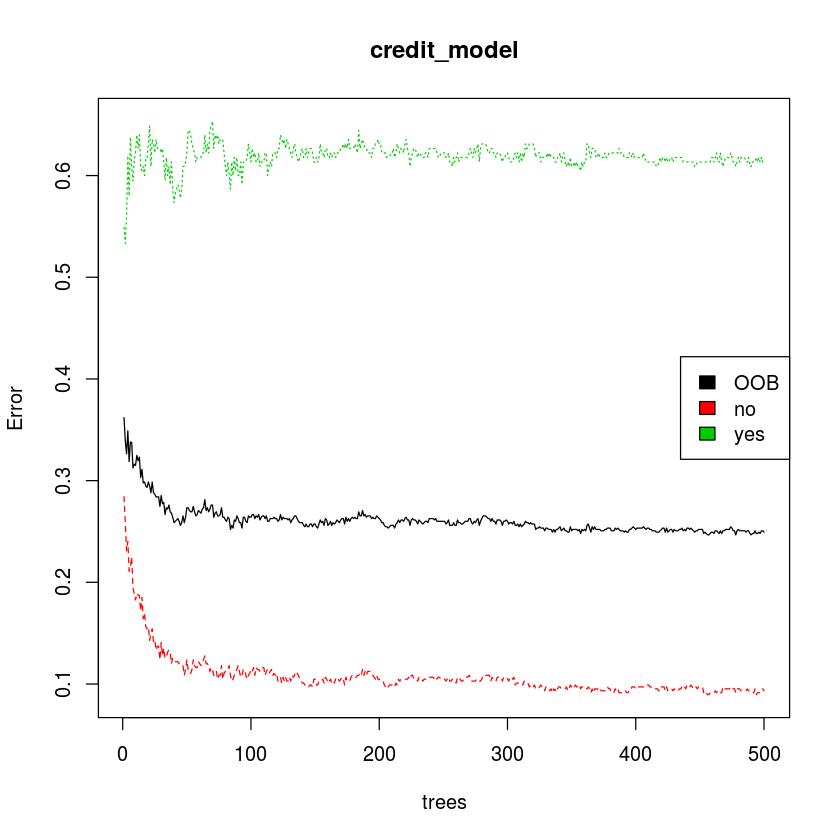

In [7]:
# Let's plot the model trained above
plot(credit_model)

# Adding a legend is a must :D
legend(x = "right", 
       legend = colnames(err),
       fill = 1:ncol(err))

In [8]:
#OOB is not discussed here because it was discussed in the notebook on bagged trees.
#Let's evaluate model performance on a test set

In [9]:
# Let's test the model
class_prediction <- predict(object = credit_model,
                            newdata = credit_test,
                            type = "class") # return classification labels
                            
# The confusion matrix for the test set
cm <- confusionMatrix(data = class_prediction,       
                      reference = credit_test$default)
print(cm)

Confusion Matrix and Statistics

          Reference
Prediction  no yes
       no  164  45
       yes  11  30
                                          
               Accuracy : 0.776           
                 95% CI : (0.7192, 0.8261)
    No Information Rate : 0.7             
    P-Value [Acc > NIR] : 0.004485        
                                          
                  Kappa : 0.3873          
 Mcnemar's Test P-Value : 1.035e-05       
                                          
            Sensitivity : 0.9371          
            Specificity : 0.4000          
         Pos Pred Value : 0.7847          
         Neg Pred Value : 0.7317          
             Prevalence : 0.7000          
         Detection Rate : 0.6560          
   Detection Prevalence : 0.8360          
      Balanced Accuracy : 0.6686          
                                          
       'Positive' Class : no              
                                          


In [10]:
# Let's compare test set accuracy to OOB accuracy
paste0("Test Accuracy: ", cm$overall[1])
paste0("OOB Accuracy: ", 1 - oob_err)

[1] "Test Accuracy: 0.776"

[1] "OOB Accuracy: 0.750666666666667"

In [11]:
#Test accuracy and OOB accuracy are close enough. OOB gives a generic idea about the performance of the model.

In [12]:
# Let's check the model accuracy with another metrics: classification error# Let's 
(ce(actual = credit_test$default, 
   predicted = class_prediction))

[1] 0.224

In [13]:
# Another famous metric is AUC/ROC. Let's calculate AUC of the predicted model.

# For that to happen we need to generate predictions on the test set
pred <- predict(object = credit_model,
            newdata = credit_test,
            type = "prob")

                
# And now compute the AUC
auc(actual = ifelse(credit_test$default == "yes", 1, 0), 
    predicted = pred[,"yes"])

[1] 0.8128762

In [14]:
#Like any machine learning algorithm, to achieve the best model we tune the hyperparameters of the model. Let's do that. Some of the key hyperparameters we are going to play with would be :

# 1) ntrees - number of trees. Default is 500.
# 2) mtry - number of variables choosen as candidates to train at each split. Default is sqrt(total input features)
# 3) sampsize - number of samples to train on. Default to 63.2%

#There are two other important parameters but we are not covering them here.
#nodesize - minimum size of the terminal nodes, helps in controlling the complexity. 
        #Lesser the nodesize -> more complex the tree.
#maxnodes - maximum number of terminal nodes, helps in controlling the complexity and in avoiding overfitting.
#The most important of the hyperparameters is mtry. Let's fix that first.

mtry = 4  OOB error = 24.4% 
Searching left ...
mtry = 2 	OOB error = 25.47% 
-0.04371585 0.05 
Searching right ...
mtry = 8 	OOB error = 25.2% 
-0.03278689 0.05 
      mtry  OOBError
2.OOB    2 0.2546667
4.OOB    4 0.2440000
8.OOB    8 0.2520000


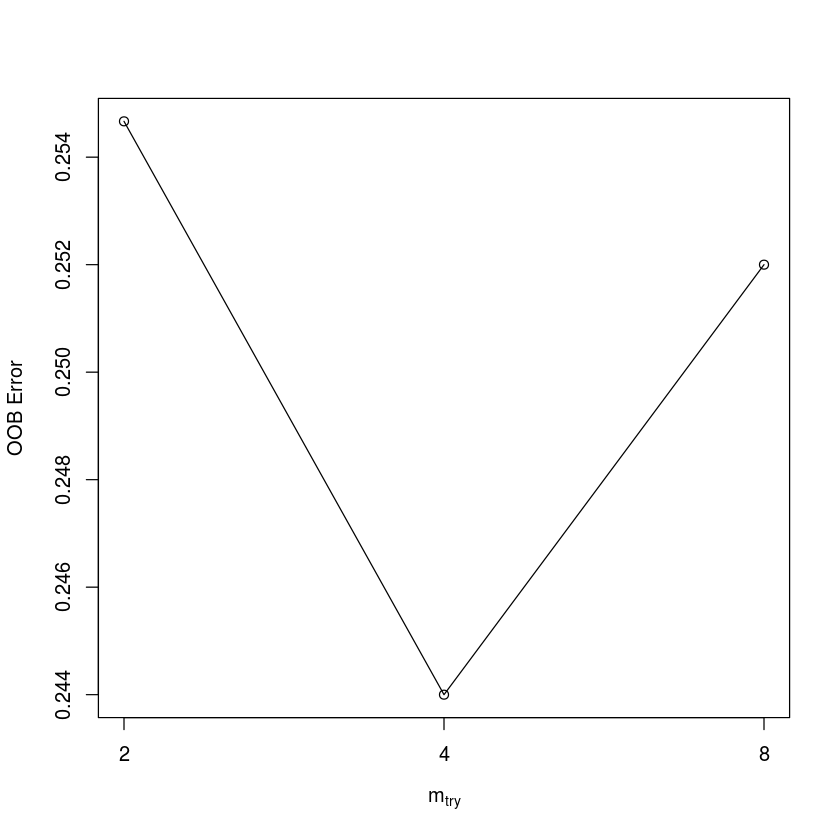

In [15]:
# Let's start the tuning process    
res <- tuneRF(x = subset(credit_train, select = -default),
              y = credit_train$default,
              ntreeTry = 500)
               
# Look at results
print(res)

In [16]:
# Find the mtry value that minimizes OOB Error# Find t 
mtry_opt <- res[,"mtry"][which.min(res[,"OOBError"])]
print(mtry_opt)

4.OOB 
    4 


In [17]:
#Therefore the best mtry value is 1.
#Previously, we trained mtry using the tune function provided by randomForest. However, let's tune it using a grid of all possible combinations.

In [18]:
# Setting seed for reproducible train and test partitions
set.seed(123)

# List of possible values for mtry, nodesize and sampsize
mtry <- seq(4, ncol(credit_train) * 0.8, 2)
nodesize <- seq(3, 8, 2)
sampsize <- nrow(credit_train) * c(0.7, 0.8)

# Create a data frame containing all combinations 
hyper_grid <- expand.grid(mtry = mtry, nodesize = nodesize, sampsize = sampsize)

# Create an empty vector to store OOB error values and model
oob_err <- c()
model_vec <- list()

# Loop over the rows of hyper_grid to train the grid of models
for (i in 1:nrow(hyper_grid)) {

    model <- randomForest(formula = default ~ ., 
                          data = credit_train,
                          mtry = hyper_grid$mtry[i],
                          nodesize = hyper_grid$nodesize[i],
                          sampsize = hyper_grid$sampsize[i])
                          
    # Store OOB error for the model                      
    oob_err[i] <- model$err.rate[nrow(model$err.rate), "OOB"]
    model_vec[[i]] <- model
}

# Identify optimal set of hyperparmeters based on OOB error
(opt_i <- which.min(oob_err))
print(hyper_grid[opt_i,])

[1] 22

   mtry nodesize sampsize
22    6        5      600


In [19]:
model_vec[[9]] #best model


Call:
 randomForest(formula = default ~ ., data = credit_train, mtry = hyper_grid$mtry[i],      nodesize = hyper_grid$nodesize[i], sampsize = hyper_grid$sampsize[i]) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 10

        OOB estimate of  error rate: 24.8%
Confusion matrix:
     no yes class.error
no  470  55   0.1047619
yes 131  94   0.5822222

In [20]:
#Let's check out the results of our final model on the test dataset.

In [21]:
class_prediction <- predict(object = model_vec[[9]],
                            newdata = credit_test,
                            type = "class") # return classification labels
                            
# The confusion matrix for the test set
cm <- confusionMatrix(data = class_prediction,       
                      reference = credit_test$default)
print(cm)

Confusion Matrix and Statistics

          Reference
Prediction  no yes
       no  160  46
       yes  15  29
                                          
               Accuracy : 0.756           
                 95% CI : (0.6979, 0.8079)
    No Information Rate : 0.7             
    P-Value [Acc > NIR] : 0.0294501       
                                          
                  Kappa : 0.3413          
 Mcnemar's Test P-Value : 0.0001225       
                                          
            Sensitivity : 0.9143          
            Specificity : 0.3867          
         Pos Pred Value : 0.7767          
         Neg Pred Value : 0.6591          
             Prevalence : 0.7000          
         Detection Rate : 0.6400          
   Detection Prevalence : 0.8240          
      Balanced Accuracy : 0.6505          
                                          
       'Positive' Class : no              
                                          


In [22]:
#I would be coming up with some new things in it soon.